# Knn Regression

1. Choose K (the number of clusters you want).

2. Initialize K centroids randomly.

3. Repeat until convergence:
   a. Assign each data point to the nearest centroid.
   b. Recalculate the centroids based on the current assignment of data points.
   
4. Return the final K centroids and the corresponding cluster assignments.


### Import Modules and Read Dataset

In [176]:
# import modules 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline 

In [177]:
df = pd.read_csv('../cleaning-preprocessing/cleaned_flight_data_with_target.csv')
# df.head(5)

In [178]:
df = df.astype(int)
# df.head(5)

In [179]:
# Spliting the dataset
# Getting DEP_DELAY for the once only delay 
# any positive values means that it is early departure

df = df[df['DEP_DELAY'] > 0]
df = df.head(1000)

### Transformation Testing

4.820893338359548
0.25029895337632907
0.027436832341569406


/Users/engineererjojo/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/engineererjojo/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/engineererjojo/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


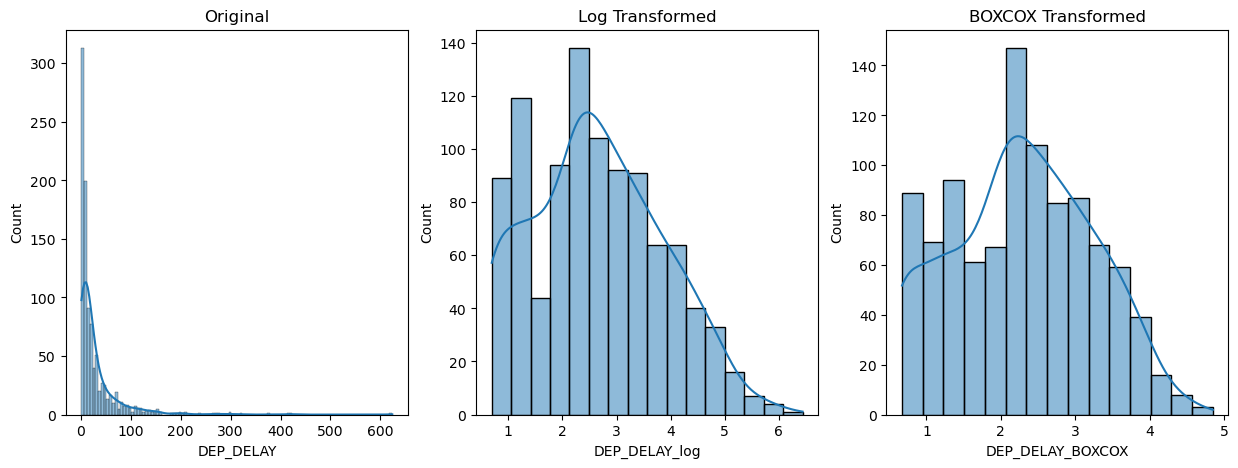

In [180]:
print(df['DEP_DELAY'].skew())  # If > 0.5 or < -0.5, transformation is needed

df['DEP_DELAY_shifted'] = df['DEP_DELAY'] - df['DEP_DELAY'].min() + 1
# df['DEP_DELAY_log'] = np.log1p(df['DEP_DELAY_shifted'])

df['DEP_DELAY_log'] = np.log1p(df['DEP_DELAY_shifted'])  # log1p avoids log(0) issue
df['DEP_DELAY_sqrt'] = np.sqrt(df['DEP_DELAY_shifted']) # sqrt version

from scipy.stats import boxcox
df['DEP_DELAY_BOXCOX'], lambda_ = boxcox(df['DEP_DELAY_shifted'] + 1)  # Adding 1 to avoid issues with 0

print(df['DEP_DELAY_log'].skew())
print(df['DEP_DELAY_BOXCOX'].skew())

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(df['DEP_DELAY'], kde=True, ax=axes[0])
axes[0].set_title('Original')

sns.histplot(df['DEP_DELAY_log'], kde=True, ax=axes[1])
axes[1].set_title('Log Transformed')

sns.histplot(df['DEP_DELAY_BOXCOX'], kde=True, ax=axes[2])
axes[2].set_title('BOXCOX Transformed')

plt.show()

4.820893338359548
0.25029895337632907
-0.4143707443889286


/Users/engineererjojo/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/engineererjojo/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/engineererjojo/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


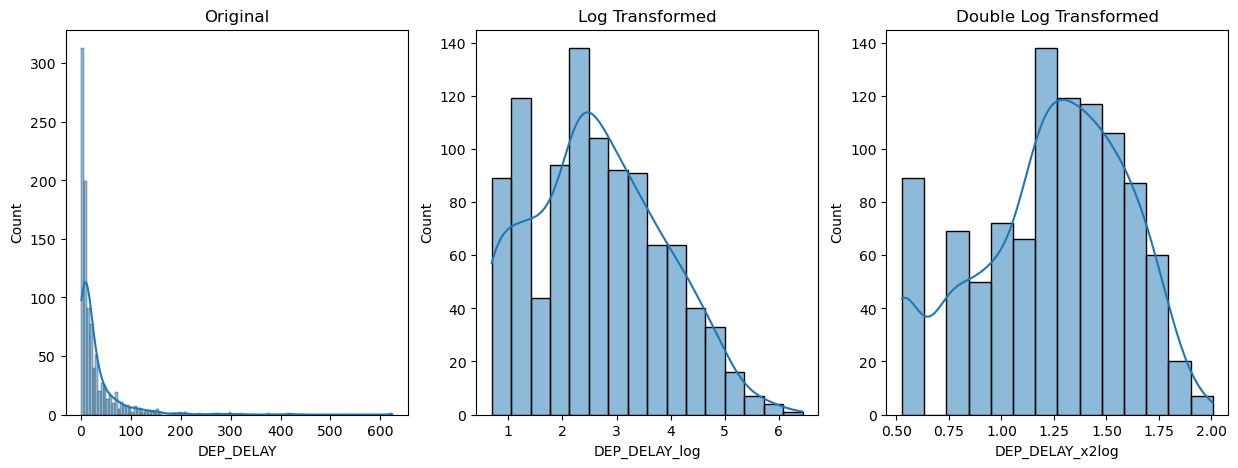

In [181]:
print(df['DEP_DELAY'].skew())  # If > 0.5 or < -0.5, transformation is needed

df['DEP_DELAY_shifted'] = df['DEP_DELAY'] - df['DEP_DELAY'].min() + 1
df['DEP_DELAY_log'] = np.log1p(df['DEP_DELAY_shifted'])

df['DEP_DELAY_log'] = np.log1p(df['DEP_DELAY_shifted'])  # log1p avoids log(0) issue
df['DEP_DELAY_x2log'] = np.log1p(df['DEP_DELAY_log']) # sqrt version

print(df['DEP_DELAY_log'].skew()) 
print(df['DEP_DELAY_x2log'].skew()) 

fig, axes = plt.subplots(1, 3, figsize=(15, 5))


sns.histplot(df['DEP_DELAY'], kde=True, ax=axes[0])
axes[0].set_title('Original')

sns.histplot(df['DEP_DELAY_log'], kde=True, ax=axes[1])
axes[1].set_title('Log Transformed')

sns.histplot(df['DEP_DELAY_x2log'], kde=True, ax=axes[2])
axes[2].set_title('Double Log Transformed')

plt.show()

In [182]:
df['DEP_DELAY_BOXCOX']

2       3.142395
9       1.301006
14      3.805206
26      1.495255
30      1.780671
          ...   
3913    1.044581
3915    2.283104
3916    2.073672
3941    3.440988
3944    1.301006
Name: DEP_DELAY_BOXCOX, Length: 1000, dtype: float64

In [183]:
X = df.drop(columns=['DEP_DELAY_log', 'DEP_DELAY','DEP_DELAY_shifted', 'DEP_DELAY_sqrt', 'DEP_DELAY_x2log', 'DEP_DELAY_BOXCOX']) #Dropping DEP_DELAY Log/Sqrt transform cols

# Using Single Log Transformation
y = df['DEP_DELAY_log']  # Target variable

# Using Double Log Transformation
# y = df['DEP_DELAY_x2log']  # Target variable

# Using BoxCox Transformation
# y = df['DEP_DELAY_BOXCOX'] # Target variable

y.head(3)

2     3.713572
9     1.386294
14    4.691348
Name: DEP_DELAY_log, dtype: float64

### Feature Selection (Post Log Transformation)

In [184]:
X = X.applymap(lambda x: max(x, 0))
X = X.fillna(X.mean())

/var/folders/06/6rnd9mvj2tg64m2vg9cssn0w0000gn/T/ipykernel_20721/3256436071.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: max(x, 0))


In [185]:
k_num_features = 10

In [186]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SelectKBest with f_regression
k = k_num_features  # Number of top features to select
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(X_scaled, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]

# Create a DataFrame with feature names and scores
feature_df = pd.DataFrame({'Feature': selected_features, 'F-Score': feature_scores})
feature_df = feature_df.sort_values(by='F-Score', ascending=False)

# Print the selected features
print("Selected Features:")
print(feature_df)

Selected Features:
                   Feature    F-Score
1                 DISTANCE  31.400982
0         CRS_ELAPSED_TIME  31.247904
5     OP_UNIQUE_CARRIER_DL  17.871493
3                  sch_dep  15.079073
2                 Pressure  14.284631
8                 DEST_PWM   9.385921
7                 DEST_BWI   8.621603
9  Condition_Partly Cloudy   7.432979
4     OP_UNIQUE_CARRIER_B6   7.413567
6                 DEST_BTV   7.311809


### Log TransFormation

In [187]:
X['sch_dep_log'] = np.log1p(X['sch_dep'])  #Top1 Feature 
X['DISTANCE_log'] = np.log1p(X['DISTANCE'])  #Top2 Feature
X['CRS_ELAPSED_TIME_log'] = np.log1p(X['CRS_ELAPSED_TIME'])  #Top3 Feature

X['OP_UNIQUE_CARRIER_DL_log'] = np.log1p(X['OP_UNIQUE_CARRIER_DL'])  #Top4  Feature
X['Wind_Speed_log'] = np.log1p(X['Wind Speed'])  #Top5  Feature
X['CRS_DEP_M_log'] = np.log1p(X['CRS_DEP_M']) #Top6  Feature

X['Pressure_log'] = np.log1p(X['Pressure']) #Top7  Feature
X['OP_UNIQUE_CARRIER_MQ_log'] = np.log1p(X['OP_UNIQUE_CARRIER_MQ'])  #Top8  Feature
X['OP_UNIQUE_CARRIER_B6_log'] = np.log1p(X['OP_UNIQUE_CARRIER_B6'])  #Top9  Feature

X['Condition_Cloudy / Windy_log'] = np.log1p(X['Condition_Cloudy / Windy'])  #Top10  Feature
X['DEST_BWI_log'] = np.log1p(X['DEST_BWI'])  #Top11  Feature
X['DEST_BUF_log'] = np.log1p(X['DEST_BUF'])  #Top12  Feature

X['DEST_BTV_log'] = np.log1p(X['DEST_BTV'])  #Top13  Feature
X['DEST_LAX_log'] = np.log1p(X['DEST_LAX'])  #Top14  Feature
X['DEST_BOS_log'] = np.log1p(X['DEST_BOS'])  #Top15  Feature



/var/folders/06/6rnd9mvj2tg64m2vg9cssn0w0000gn/T/ipykernel_20721/477951442.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X['sch_dep_log'] = np.log1p(X['sch_dep'])  #Top1 Feature
/var/folders/06/6rnd9mvj2tg64m2vg9cssn0w0000gn/T/ipykernel_20721/477951442.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X['DISTANCE_log'] = np.log1p(X['DISTANCE'])  #Top2 Feature
/var/folders/06/6rnd9mvj2tg64m2vg9cssn0w0000gn/T/ipykernel_20721/477951442.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

In [188]:
# Drop columns that are log transform
X = X.drop(columns=[
    # 'sch_dep', 
                    'DISTANCE', 
                    'CRS_ELAPSED_TIME', 
                    'OP_UNIQUE_CARRIER_DL', 
                    # 'Wind Speed', 
                    # 'CRS_DEP_M',
                    'Pressure', 
                    'OP_UNIQUE_CARRIER_MQ',
                    'OP_UNIQUE_CARRIER_B6', 
                    'Condition_Cloudy / Windy',
                    'DEST_BWI', 
                    'DEST_BUF',
                    'DEST_BTV', 
                    'DEST_LAX', 
                    'DEST_BOS'
                    ])

X = X.drop(columns=[
    'sch_dep_log',
    'Wind_Speed_log',
    'CRS_DEP_M_log'
])

### Comparsing F-Score of Log-Feature 
Check Feature Selection F-Score Again

In [189]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SelectKBest with f_regression
k = k_num_features - 5 # Number of top features to select
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(X_scaled, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]

# Create a DataFrame with feature names and scores
feature_df = pd.DataFrame({'Feature': selected_features, 'F-Score': feature_scores})
feature_df = feature_df.sort_values(by='F-Score', ascending=False)

# Print the selected features
print("Selected Features (New Comparsion):")
print(feature_df)

Selected Features (New Comparsion):
                    Feature    F-Score
1              DISTANCE_log  39.852687
2      CRS_ELAPSED_TIME_log  38.830122
3  OP_UNIQUE_CARRIER_DL_log  17.871493
0                   sch_dep  15.079073
4              Pressure_log  14.284631


### Split Training and Test Data 80:20

In [190]:
rs = 6

In [191]:
from sklearn.model_selection import train_test_split 
# X needs to be updated 

X_train, X_test, y_train, y_test = train_test_split(X[feature_df['Feature']], y, test_size = 0.2, random_state = 27)

In [192]:
# X_train

In [193]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### KNN Model

In [194]:
from sklearn.neighbors import KNeighborsRegressor
# regressor = KNeighborsRegressor(n_neighbors=91, metric='manhattan', weights='distance')
regressor = KNeighborsRegressor(n_neighbors=91, metric='euclidean',  weights='distance')

regressor.fit(X_train, y_train)

KNeighborsRegressor(metric='euclidean', n_neighbors=91, weights='distance')

### Results (MSE, MAE,  Predic vs Acutal Graph)

In [215]:
y_pred_log = regressor.predict(X_test)

# 1 log transformation
y_pred = np.exp(y_pred_log)

# 2 log transformation
# y_pred = np.exp(np.exp(y_pred_log))  

# y_test = np.exp(np.exp(y_test))

In [216]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
# print(f"R-Squared (R2): {r2:.4f}")


Model Performance Metrics:
Mean Squared Error (MSE): 318.17
Mean Absolute Error (MAE): 13.17


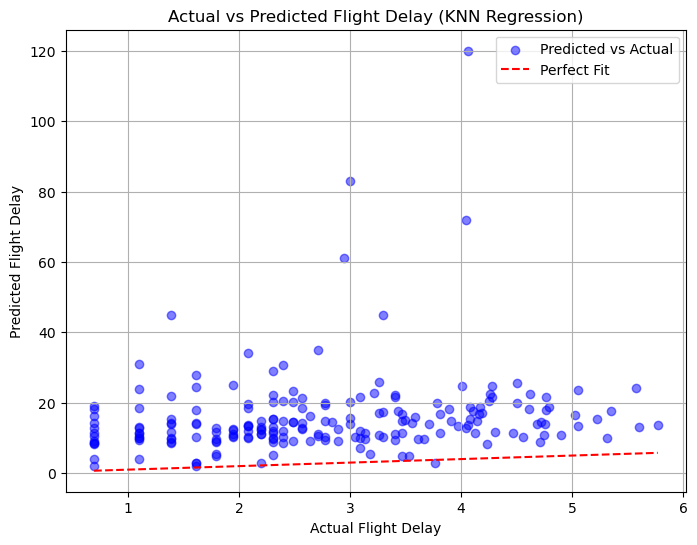

In [217]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit")

plt.xlabel("Actual Flight Delay")
plt.ylabel("Predicted Flight Delay")
plt.title("Actual vs Predicted Flight Delay (KNN Regression)")
plt.legend()
plt.grid(True)
plt.show()

In [218]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(3, 100, 2)}
grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train)
print("Best k:", grid.best_params_)

Best k: {'n_neighbors': 91}
